S.Sai Kumar 
E22CSEU1052
B36

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.3 MB/s eta 0:00:00


Estimated Gaussian noise standard deviation = 0.14753311844391814


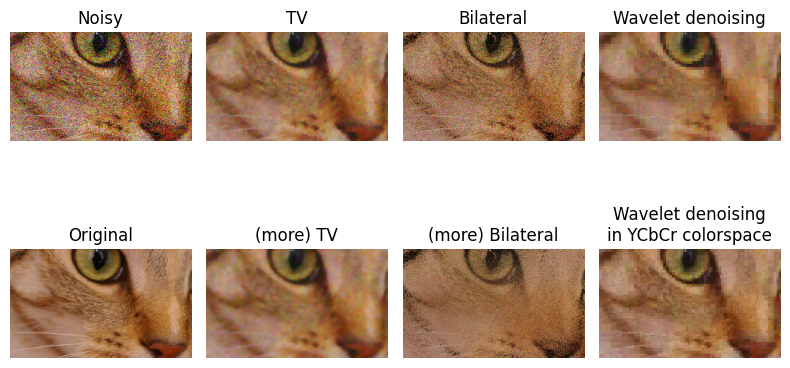

In [ ]:
import matplotlib.pyplot as plt

from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage import data, img_as_float
from skimage.util import random_noise


original = img_as_float(data.chelsea()[100:250, 50:300])

sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, channel_axis=-1))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(
    denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
)
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, channel_axis=-1, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, channel_axis=-1))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(
    denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15, channel_axis=-1)
)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(
    denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True, rescale_sigma=True)
)
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

In [ ]:
import os, random, shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
VIDEO_IN = '/content/test2.mp4'
FRAME_DIR = '/content/frames'
os.makedirs(FRAME_DIR, exist_ok=True)
cap = cv2.VideoCapture(VIDEO_IN)
idx = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    cv2.imwrite(f'{FRAME_DIR}/frame_{idx:04d}.png', frame)
    idx += 1
cap.release()

In [ ]:
# Process each frame: adaptive thresholding, Gaussian blur, Canny, bitwise_not
OUT_DIRS = {"thr":{},"blur":{},"canny":{},"inv":{}}
for op in OUT_DIRS: os.makedirs(f'/content/{op}', exist_ok=True)
for file in sorted(os.listdir(FRAME_DIR)):
    img = cv2.imread(f'{FRAME_DIR}/{file}', cv2.IMREAD_GRAYSCALE)
    thr = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY,11,2)
    blur = cv2.GaussianBlur(img,(5,5),0)
    can = cv2.Canny(img,100,200)
    inv = cv2.bitwise_not(img)
    cv2.imwrite(f'/content/thr/{file}', thr)
    cv2.imwrite(f'/content/blur/{file}', blur)
    cv2.imwrite(f'/content/canny/{file}', can)
    cv2.imwrite(f'/content/inv/{file}', inv)

In [ ]:
# Recreate videos from processed frames
def frames_to_video(frame_folder, out_video):
    files = sorted(os.listdir(frame_folder))
    frame = cv2.imread(os.path.join(frame_folder, files[0]))
    h, w = frame.shape[:2]
    writer = cv2.VideoWriter(out_video, cv2.VideoWriter_fourcc(*'mp4v'), 20, (w,h), isColor=False)
    for f in files:
        img = cv2.imread(os.path.join(frame_folder,f), cv2.IMREAD_GRAYSCALE)
        writer.write(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
    writer.release()

for op in ['thr','blur','canny','inv']:
    frames_to_video(f'/content/{op}', f'/content/{op}.mp4')

(-0.5, 2559.5, 1279.5, -0.5)

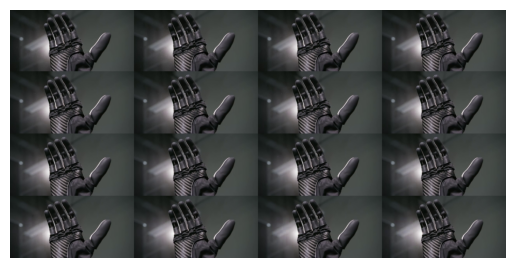

In [ ]:
# Build a collage of the first 16 original frames
grid = []
files = sorted(os.listdir(FRAME_DIR))[:16]
imgs = [cv2.imread(f'{FRAME_DIR}/{f}') for f in files]
rows = [imgs[i*4:(i+1)*4] for i in range(4)]
collage = np.vstack([np.hstack(r) for r in rows])
cv2.imwrite('/content/collage.png', collage)
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB)); plt.axis('off')

🎬 Task 2: Video Classification (CNN + LSTM)

In [ ]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model,to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
seed_c=20
np.random.seed(seed_c)
random.seed(seed_c)
tf.random.set_seed(seed_c)

In [ ]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!unrar x UCF101.rar

Total no of class:101


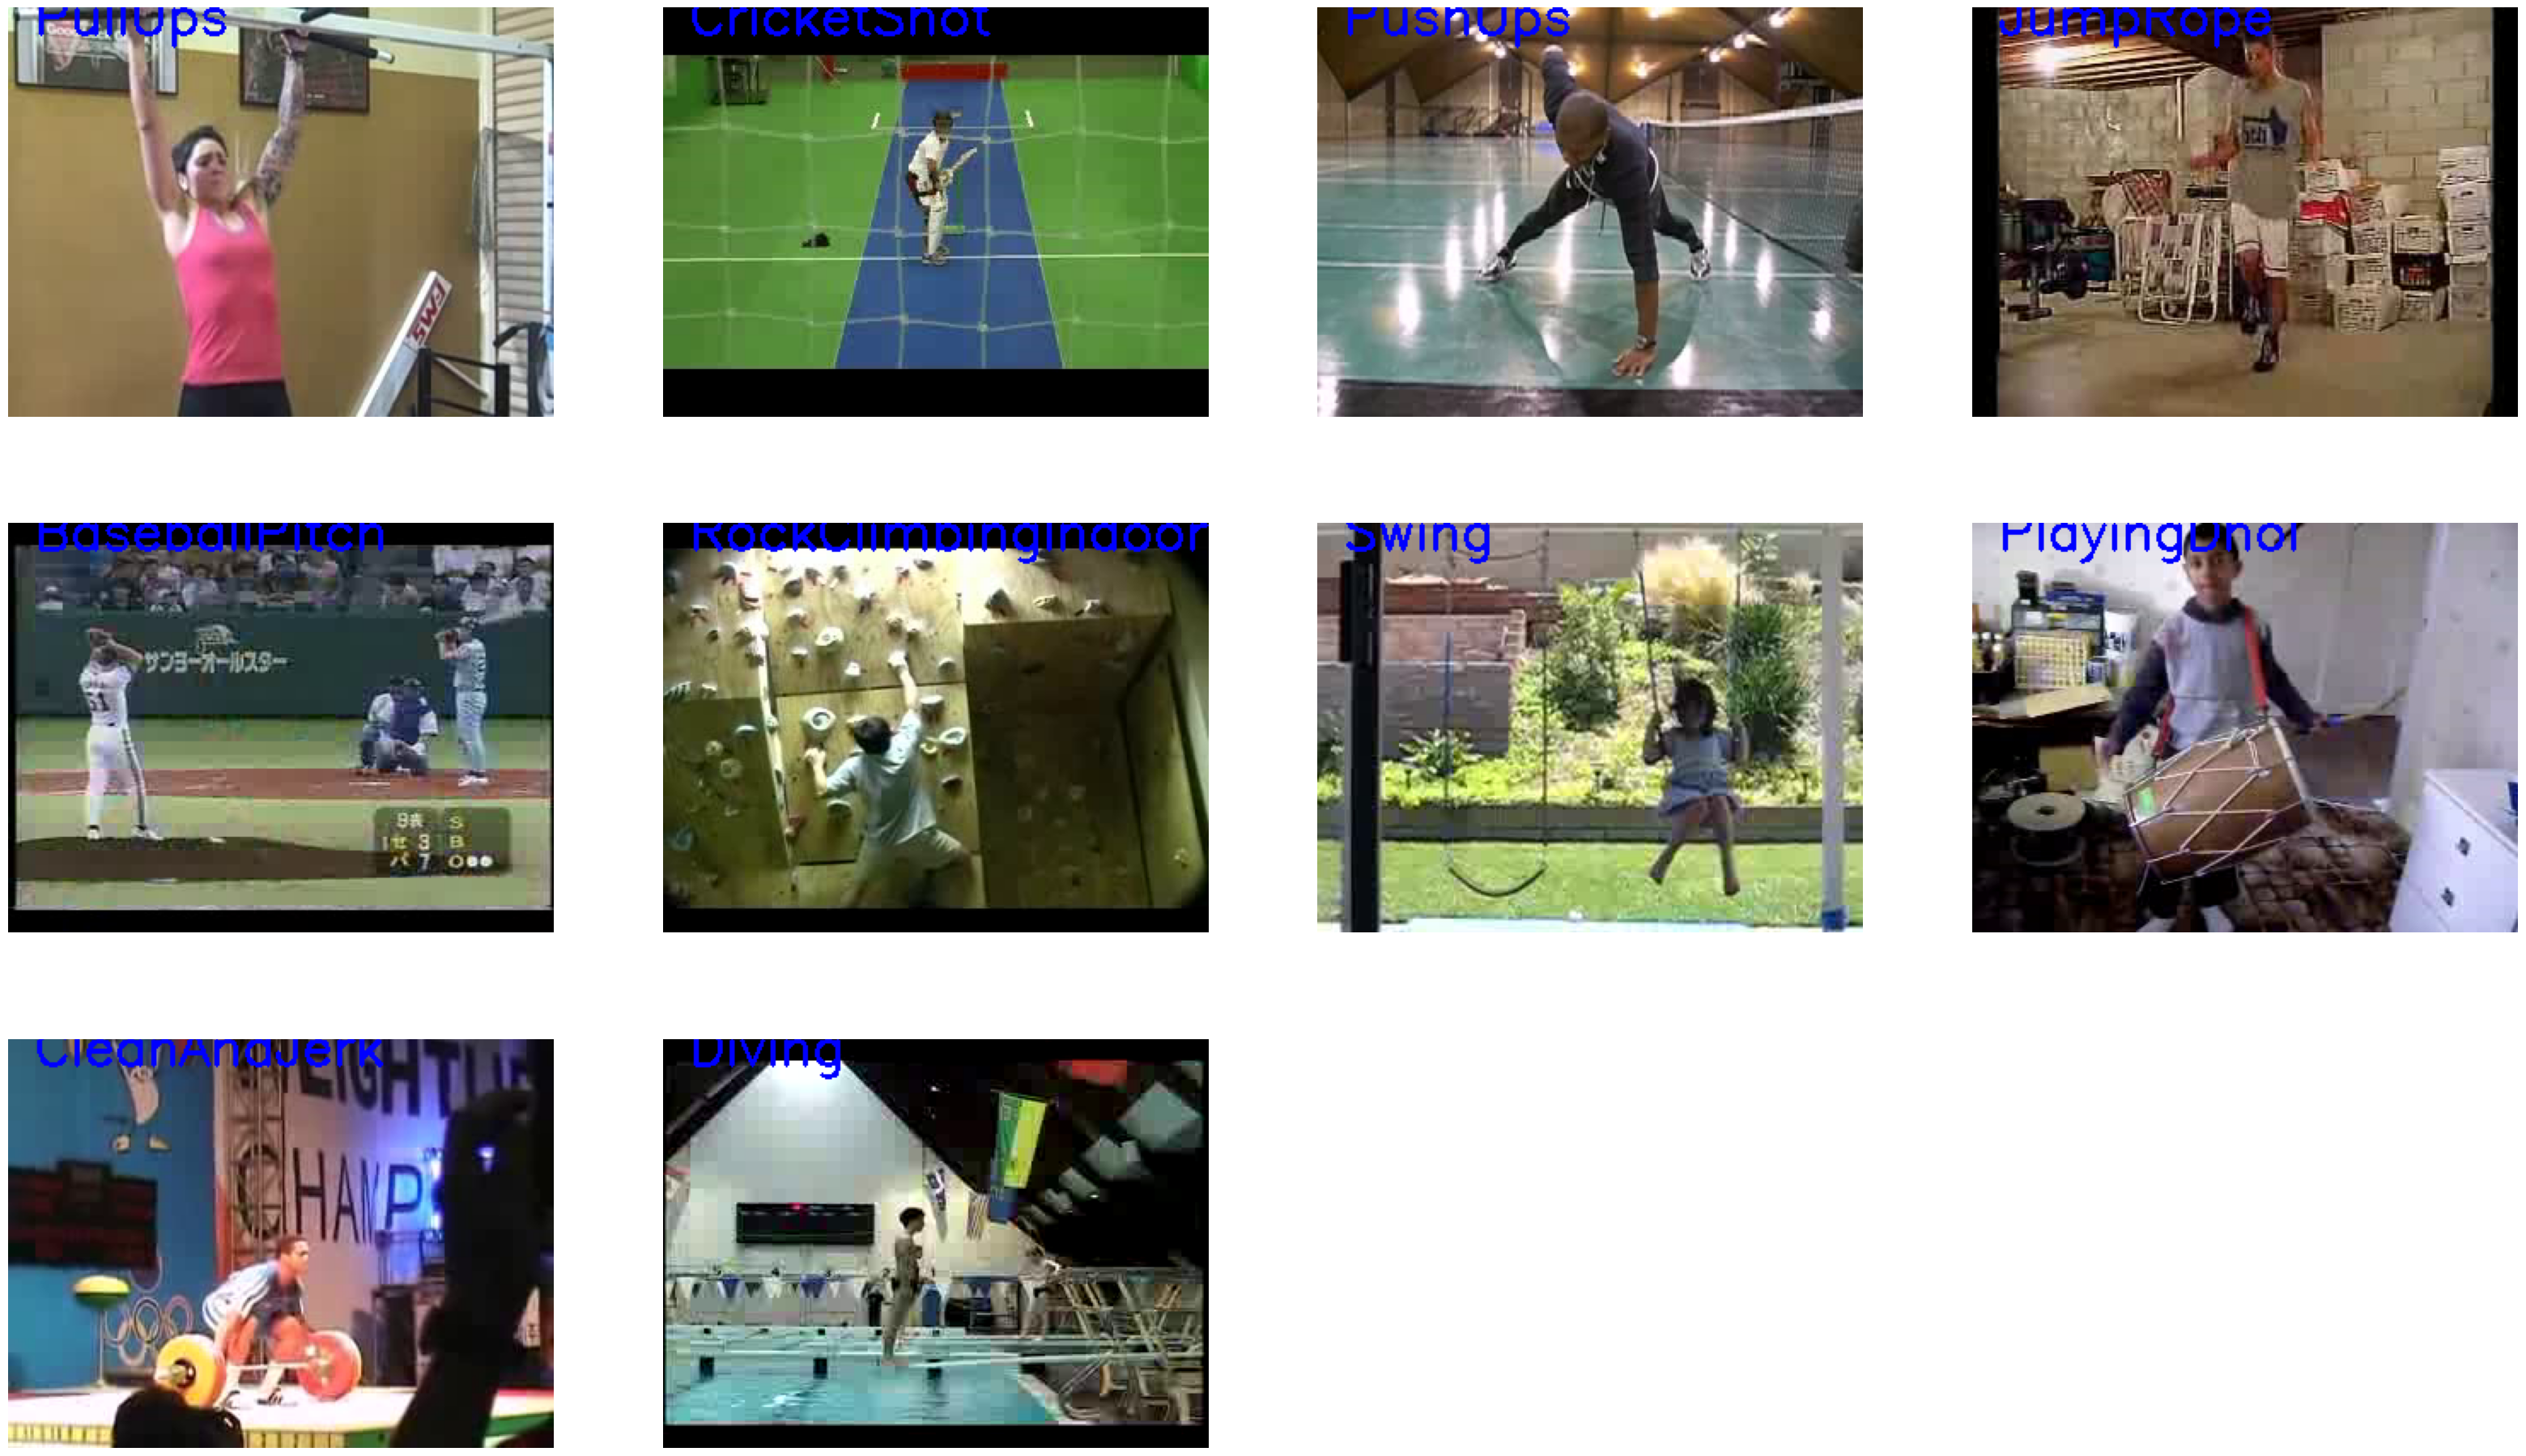

In [ ]:
plt.figure(figsize=(40,40))
class_names=os.listdir('UCF-101')
print(f'Total no of class:{len(class_names)}')
rand_range=random.sample(range(len(class_names)),10)#taking random 20 classes
for count,index in enumerate(rand_range,1):
  # print(f'{count}/  /{index}')
  select_class_name=class_names[index]
  video_file_list=os.listdir(f'UCF-101/{select_class_name}')
  video_file_name=random.choice(video_file_list)
  video_reader=cv2.VideoCapture(f'UCF-101/{select_class_name}/{video_file_name}')
  dummy,bgr_frame=video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame,select_class_name,(15,15),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
  plt.subplot(5,4,count);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
#setting parameters
height,width=112,112
seq_len=20
dataset_dir='UCF-101'
target_class= ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
print(target_class)

['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']


In [ ]:
def frame_extraction(path):
  frame_list=[]
  cap=cv2.VideoCapture(path)
  frame_count=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frame_window=max(int(frame_count/seq_len),1)
  for counter in range(seq_len):
    cap.set(cv2.CAP_PROP_FRAME_COUNT,counter*skip_frame_window)
    success,frame=cap.read()
    if not success:
      break
    resize_img=cv2.resize(frame,(height,width))
    normalize_img=resize_img/255
    frame_list.append(normalize_img)
  cap.release()
  return frame_list

In [ ]:
def create_dataset():
  features = []
  labels = []
  video_path = []
  for index, name in enumerate(target_class):
    print(f'Extracting data of class: {name}')
    file_list = os.listdir(os.path.join(dataset_dir, name))

    # Initialize a counter for each class
    class_counter = 0

    for file_name in file_list:
      if class_counter >= 25:  # Break if we have 10 videos for this class
        break

      path = os.path.join(dataset_dir, name, file_name)
      frames = frame_extraction(path)
      if len(frames) == seq_len:
        features.append(frames)
        labels.append(index)
        video_path.append(path)
        class_counter += 1  # Increment the counter for this class

  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_path

In [ ]:
#Extractng dataset depend on target class
features,labels,video_path=create_dataset()
one_hot_encoded_label=to_categorical(labels)

Extracting data of class: Basketball
Extracting data of class: Biking
Extracting data of class: PlayingGuitar
Extracting data of class: Typing
Extracting data of class: JumpRope


In [ ]:
feature_train,feature_test,label_train,label_test=train_test_split(features,one_hot_encoded_label,test_size=0.2,shuffle=True,random_state=seed_c)


In [ ]:
num_of_class=5

In [ ]:
model=Sequential()
##################################
model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(seq_len,height,width,3))))
model.add(TimeDistributed(MaxPooling2D(4,4)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(4,4)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(32))

model.add(Dense(num_of_class,activation='softmax'))

#######################################

model.build(input_shape=(None, seq_len, height, width, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeDi  (None, 20, 112, 112, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 20, 28, 28, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 20, 28, 28, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 20, 28, 28, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 20, 7, 7, 32)    

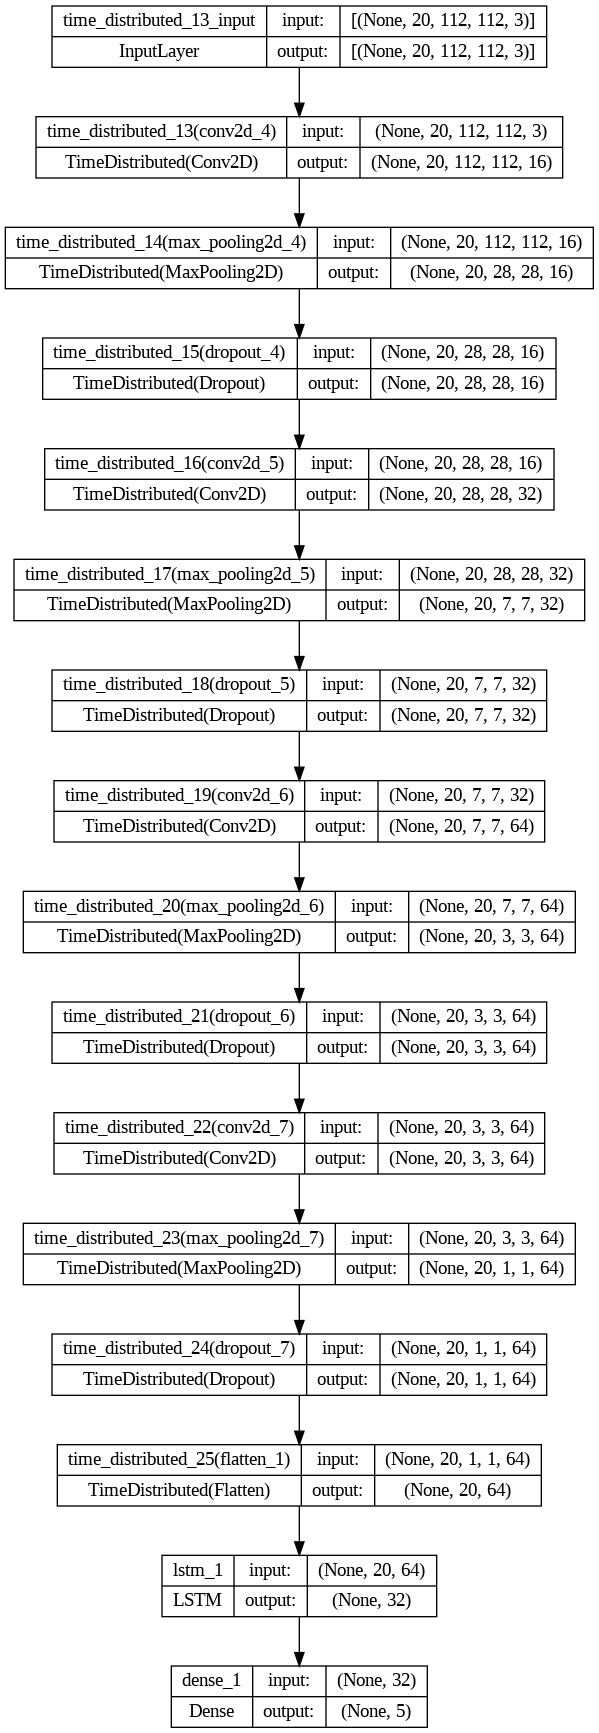

In [ ]:
plot_model(model,to_file='model_view.png',show_shapes=True,show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
start_time=time.time()
hist=model.fit(x=feature_train,y=label_train,epochs=25,batch_size=8,shuffle=True,validation_split=0.2)
end_time=time.time()
print(f'Training time is {end_time-start_time} seconds')

Epoch 1/25
10/10 [==============================] - 15s 1s/step - loss: 1.6437 - accuracy: 0.2250 - val_loss: 1.6354 - val_accuracy: 0.1500
Epoch 2/25
10/10 [==============================] - 11s 1s/step - loss: 1.5985 - accuracy: 0.2250 - val_loss: 1.6234 - val_accuracy: 0.1500
Epoch 3/25
10/10 [==============================] - 11s 1s/step - loss: 1.6062 - accuracy: 0.2375 - val_loss: 1.6144 - val_accuracy: 0.1500
Epoch 4/25
10/10 [==============================] - 11s 1s/step - loss: 1.5768 - accuracy: 0.2375 - val_loss: 1.6041 - val_accuracy: 0.1500
Epoch 5/25
10/10 [==============================] - 11s 1s/step - loss: 1.5551 - accuracy: 0.2625 - val_loss: 1.5737 - val_accuracy: 0.1500
Epoch 6/25
10/10 [==============================] - 12s 1s/step - loss: 1.4940 - accuracy: 0.4375 - val_loss: 1.4716 - val_accuracy: 0.4500
Epoch 7/25
10/10 [==============================] - 10s 1s/step - loss: 1.4971 - accuracy: 0.3625 - val_loss: 1.4917 - val_accuracy: 0.5000
Epoch 8/25
10/10 [==

In [ ]:
eval_hist=model.evaluate(feature_test,label_test)

1/1 [==============================] - 1s 1s/step - loss: 1.2248 - accuracy: 0.5200


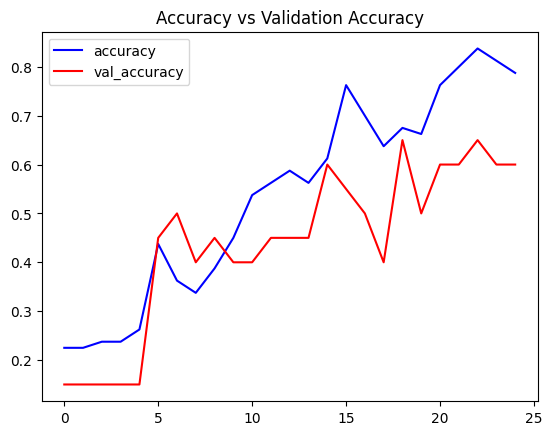

In [ ]:
#ACCURACY
x=hist.history['accuracy']
epochs=range(len(x))
plt.plot(epochs,x,'blue',label='accuracy')
plt.plot(epochs,hist.history['val_accuracy'],'red',label='val_accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend()

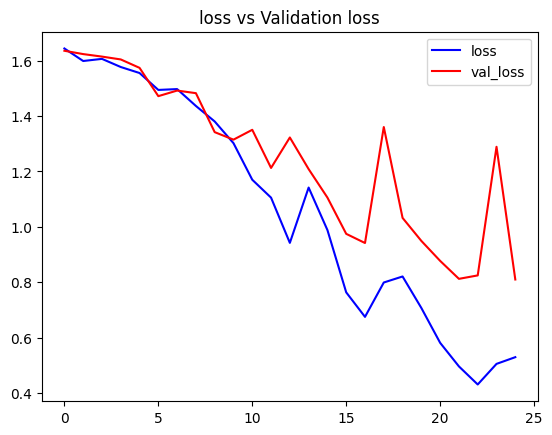

In [ ]:
#LOSS
x=hist.history['loss']
epochs=range(len(x))
plt.plot(epochs,x,'blue',label='loss')
plt.plot(epochs,hist.history['val_loss'],'red',label='val_loss')
plt.title('loss vs Validation loss')
plt.legend()

In [ ]:
#CONFUSION MATRIX & CLASSIFICATION REPORT
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred=model.predict(feature_test)
y_pred_class=np.argmax(y_pred,axis=1)
y_actual=np.argmax(label_test,axis=1)
cm=confusion_matrix(y_pred_class,y_actual)
print("Confusion matrix")
print(cm)
cr=classification_report(y_pred_class,y_actual)
print("Classification report")
print(cr)

1/1 [==============================] - 2s 2s/step
Confusion matrix
[[1 4 0 0 0]
 [0 0 0 1 2]
 [0 1 8 1 0]
 [0 0 0 3 0]
 [3 0 0 0 1]]
Classification report
              precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.00      0.00      0.00         3
           2       1.00      0.80      0.89        10
           3       0.60      1.00      0.75         3
           4       0.33      0.25      0.29         4

    accuracy                           0.52        25
   macro avg       0.44      0.45      0.43        25
weighted avg       0.58      0.52      0.54        25

